Osnabrück University - Computer Vision (Winter Term 2022/23) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack

# Exercise Sheet 05: Segmentation 2

## Introduction

This week's sheet should be solved and handed in before end of **Sunday, December 11, 2022**. If you need help (and Google and other resources were not enough), feel free to use the Stud.IP forum. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (Periodic functions) [0 Points]

This exercise is supposed to be very easy, does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What are periodic functions? Can you provide a definition?

YOUR ANSWER HERE

**b)** What are *amplitude*, *frequency*, *wave length*, and *phase* of a sine function? How can you change these properties?

YOUR ANSWER HERE

**c)** How are sine and cosine defined for complex arguments? In what sense does this generalize the real case?

YOUR ANSWER HERE

## Assignment 1: Scale space (5 points)

**a)** What is a scale space? How does it relate to an image pyramid? How is it computed?

For some background on scale spaces, you may have a look at the entry on [Scale space](http://kth.diva-portal.org/smash/get/diva2:441147/FULLTEXT01.pdf) in the Encyclopedia  of  Computer Science and Engineering.

- Scale space is a framework for multiscale image representation, it's main idea is to represent the objects in the real world which are percieved differently depending on the scale of observation.
- it's related to image pyramid, that both startegies are working on multiscale image representation. the pyramid is older technique than scale space. scale space operation is done after smoothing the image with convolution by gaussian kernel and it's derivatives, the same kernels used in pyramid. so i can used the output of pyramid technique and apply to it scale spaces techniques.

**b**) Explain the figure depicted on CV-07 slide 37. How are the zero crossings obtained? Why do they tend to form loops? How can the depicted information be used for segmentation?

- the diagram indicates the output of zero crossing technique. the output is binary image with single pixel thickness lines, showing the positions of zero crossing points.
- we can obtain the zero crossing by simulated diffusion to blur the image by a specified extend
- the zero crossing tend to form loops, because zero crossing is scale space with continous scaling parameters.
- zero crossing is used as features detector so the output information will be about features of objects (intensities, edges) in the image which will help in image segmentation

**c)** Implement the computation of a scale space. Also include code for highlighting the zero crossings at different scales to produce a visualization similar to the figure on CV-07 slide 37.

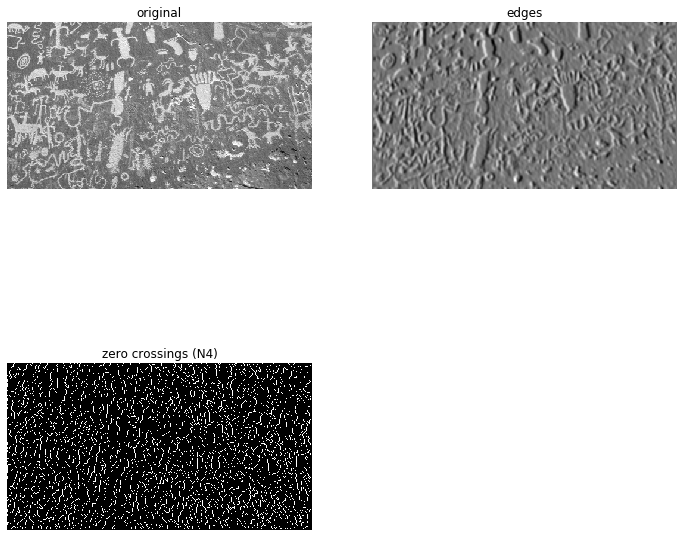

In [2]:
import imageio as imageio
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal
from skimage.filters import sobel
import cv2 
import math

# load the image
img = imageio.imread('images/NewspaperRock.png') / 255.

def abstract_method(self):
        raise NotImplemented()
        
    
        
kernel = np.array([
                        [-1, 0, 1], [-2, 0, 2], [-1, 0, 1]
                    ])



def zero_cross_detection(image):
    z_c_image = np.zeros(image.shape)

    for i in range(0,image.shape[0]-1):
        for j in range(0,image.shape[1]-1):
            if image[i][j]>0:
                if image[i+1][j] < 0 or image[i][j+1] < 0:
                    z_c_image[i,j] = 1
            
    return z_c_image

        
image = cv2.GaussianBlur(img, (5,5), cv2.BORDER_DEFAULT)       
edges = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
zero_cross = zero_cross_detection(edges)
 
    
plt.figure(figsize=(12, 24))
plt.gray()
plt.subplot(4,2,1); plt.axis('off'); plt.imshow(img); plt.title('original')
plt.subplot(4,2,2); plt.axis('off'); plt.imshow(edges); plt.title('edges')
plt.subplot(4,2,3); plt.axis('off'); plt.imshow(zero_cross); plt.title('zero crossings (N4)')
plt.show()

## Assignment 2: Texture Segmentation (5 points)

**a)** What is texture? Try to define it in your own words. Can there be a standard definition? What problems do you expect for texture based segmentation? 

Texture is certain pattern or structure in the image. Some tree images would have their own textures and sky images or water images as well. Different features have different texture. There are no standard definition about texture.

There is a problem for texture segmentation. Texture is defined only for the pixels with neighbors. But when the group of pixels include different segmentation, it is difficult to figure out. 

**b)** What is a co-occurence matrix? How can it be used to characterize texture?

The co-occurence matrix detects certain patterns in the image. If pair of image pixels which have specific distance and angle have each gray value g1 and g2, the matrix become true. With this matrix we can know the tendency of the image and that helps to know the texture. If we do this for every pixels in the image for every gray value with specific distance and angle, the tendency of full image which is stochastic texture  


**c)** Implement a function to compute the co-occurence matrix of an image (patch). Apply it and compare your results to (CV-07 slide 54).

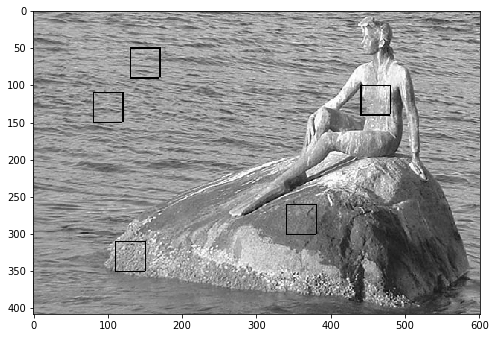

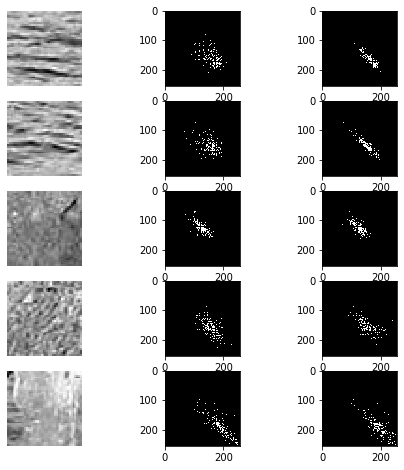

In [49]:
%matplotlib inline
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
import imageio as imageio

img = imageio.imread('images/mermaid.png')#, mode='L')

def get_patch(img, x, y, size=40):
    """
    Extract a rectangular patch from an image and mark it in the original image.
    
    Args:
        img (nndarray): Input image.
        x (uint): X-coordinate.
        y (uint): Y-coordinate.
        size (uint): Size of the patch.
        
    Returns:
        result: The extracted patch.
    """
    result = img[x:x+size,y:y+size].copy()
    img[x:x+size, [y,y+1,y+size,y+size+1]] = 0
    img[[x,x+1,x+size,x+size+1], y:y+size] = 0
    return result

patches = []
patches.append(get_patch(img, 50,130))
patches.append(get_patch(img, 110,80))
patches.append(get_patch(img, 260,340))
patches.append(get_patch(img, 310,110))
patches.append(get_patch(img, 100,440))

def cooccurrence(img, dx=1, dy=1):
    """
    Compute a co-occurence matrix for the given image.
    
    Args:
        img          the grayscale image (uint8)
        dx,dy        the offset between the two reference points

    Returns:
        matrix       the co-occurence matrix
    """
    matrix = np.zeros((256, 256))
    for g1, g2 in np.ndindex(matrix.shape):
        if (dx == 0) :
            if not np.all((img[:-dy, :] - g1) | (img[dy:, :] - g2)) :
                matrix[g1,g2] += 1
        elif (dy == 0) :
            if not np.all((img[:, :-dx] - g1) | (img[:, dx:] - g2)) :
                matrix[g1,g2] += 1
        else :
            if not np.all((img[:-dy, :-dx] - g1) | (img[dy:, dx:] - g2)) :
                matrix[g1,g2] += 1
    return matrix


plt.figure(figsize=(8, 8))
plt.gray()
plt.imshow(img)
plt.show()


plt.figure(figsize=(8, 8))
i = 0
for p in patches:
    plt.subplot(len(patches),3,i+1); plt.axis('off'); plt.imshow(p)
    # For visualization one may apply some extra me, e.g., logarithmization or binarization
    plt.subplot(len(patches),3,i+2); plt.imshow(np.log(1 + cooccurrence(p, 0, 1)), interpolation='none')
    plt.subplot(len(patches),3,i+3); plt.imshow(cooccurrence(p,1,0)>0, interpolation='none')
    i += 3
plt.show()

## Assignment 3: Edge-based segmentation  (5 points)

### a) Gradients
What is the gradient of a pixel? How do we calculate the first, how the second derivative of an image?  

YOUR ANSWER HERE

### b) Edge linking

Describe in your own words the idea of edge linking. What is the goal? Why does it not necessarily yield closed
edge contours?

YOUR ANSWER HERE

### c) Zero crossings

Explain what zero crossings are. Why does the detection of zero crossings always lead to closed contours?

YOUR ANSWER HERE

### d) Zero crossings (implementation)

Provide an implementation of the zero crossing procedure described in (CV-07 slide 71). To get sensible results you should smooth the image before applying the Laplacian filter, e.g. using the Laplacian of a Gaussian (you may use buildin functions for the filterings steps).

In [ ]:
from skimage import filters
from skimage.feature import canny
from skimage.color import rgb2gray
from imageio.v3 import imread
import matplotlib.pyplot as plt
import numpy as np
import cv2 
from skimage.util import random_noise
%matplotlib inline

img = imread('images/swampflower.png').astype(float)
#img = imread('images/peppers.png').astype(float)


if len(img.shape)>2:
    img = rgb2gray(img)
img /= img.max()


kernel = np.array([
                        [0, 1, 0], [1, -4, 1], [0, 1, 0]
                    ])

# Now compute edges and then zero crossings using the 4-neighborhood and the 8-neighborhood
# YOUR CODE HERE
def abstract_method(self):
        raise NotImplemented()
        
laplacian = cv2.Laplacian(img,cv2.CV_64F)
edges = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)  
#sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

def zero_cross_detection_n4(image):
    z_c_image = np.zeros(image.shape)

    for i in range(0,image.shape[0]-1):
        for j in range(0,image.shape[1]-1):
            if image[i][j]>0:
                if image[i+1][j] < 0 or image[i][j+1] < 0:
                    z_c_image[i,j] = 1
            
    return z_c_image

def zero_cross_detection_n8(image):
    z_c_image = np.zeros(image.shape)

    for i in range(0,image.shape[0]-1):
        for j in range(0,image.shape[1]-1):
            if image[i][j]>0:
                if image[i+1][j-1] < 0 or image[i+1][j+1] < 0:
                    z_c_image[i,j] = 1
                    
    return z_c_image

zero_crossings_n4 = zero_cross_detection_n4(edges)
zero_crossings_n8 = zero_cross_detection_n8(edges)

sx = ndimage.sobel(img,axis=0,mode='constant')
sy = ndimage.sobel(img,axis=1,mode='constant')

grad_mag=np.hypot(sx,sy)



plt.figure(figsize=(12, 24))
plt.gray()
plt.subplot(4,2,1); plt.axis('off'); plt.imshow(img); plt.title('original')
plt.subplot(4,2,2); plt.axis('off'); plt.imshow(edges); plt.title('edges')
plt.subplot(4,2,3); plt.axis('off'); plt.imshow(zero_crossings_n4); plt.title('zero crossings (N4)')
plt.subplot(4,2,4); plt.axis('off'); plt.imshow(zero_crossings_n8); plt.title('zero crossings (N8)' )
plt.subplot(4,2,5); plt.axis('off'); plt.imshow(grad_mag); plt.title('Gradient Magnitude' )
plt.subplot(4,2,6); plt.hist(grad_mag.flatten(), 255, (0, grad_mag.max())); plt.title('Histogram Gradient Magnitude' )
plt.subplot(4,2,7); plt.axis('off'); plt.imshow(zero_crossings_n8_thresh); plt.title('zero crossings (N8) Thresh' )
plt.subplot(4,2,8); plt.axis('off'); plt.imshow(canny(img,sigma=2)); plt.title('Canny')
plt.show()

## Assignment 4: Watershed transform  (5 points)



### a) Watershed transform

Explain in your own words the idea of watershed transform. How do the two different approaches from the lecture work? Why does watershed transform always give a closed contour?



YOUR ANSWER HERE

### b) Implementation

Now implement the watershed transform using the flooding approach (CV-07 slide 76, but note, that the algorithm presented there is somewhat simplified!). Obviously, buildin functions for computing watershed transform are not allowed, but all other functions may be used. In this example we appply the watershed transform to a distance transformed image, so you **do not** have to take the gradient image, but can apply the watershed transform directly.

In [ ]:
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt
%matplotlib inline

def getNeighbors(img,x,y):
    """
    Returns the edge sensitive 8-Neighborhood of a given pixel
    
    """
    neighbors = np.empty(0)
    if(x>0 and y>0):
        neighbors = np.append(neighbors, [img[x-1,y-1]]) #top left
    if(x>0):
        neighbors = np.append(neighbors, [img[x-1,y]]) #top center
    if(y>0):
        neighbors = np.append(neighbors, [img[x,y-1]]) # left center
    if(y>0 and x<img.shape[0]-1):
        neighbors = np.append(neighbors, [img[x+1,y-1]])# bottom left
    if(x>0 and y<img.shape[1]-1):
        neighbors = np.append(neighbors, [img[x-1,y+1]]) # top right
    if(y<img.shape[1]-1):
        neighbors = np.append(neighbors, [img[x,y+1]]) # right center
    if(y<img.shape[0]-1 and x<img.shape[0]-1):
        neighbors = np.append(neighbors, [img[x+1,y+1]]) # bottom right
    if(x<img.shape[0]-1):
        neighbors = np.append(neighbors, [img[x+1,y]]) # bottom center
        
    return neighbors

def getNeighborLabels(label,x,y):
    """
    Returns the labels of the edge sensitive 8-Neighborhood of a given pixel, if there was a Label assigned already
    
    """
    
    nLabels = np.empty(0)
    
    if(x>0 and y>0):
        if(label[x-1,y-1] != 0):
            nLabels = np.append(nLabels, [label[x-1,y-1]]) # top left
    if(x>0):
        if(label[x-1,y] != 0):
            nLabels = np.append(nLabels, [label[x-1,y]]) # top center
    if(y>0):
        if(label[x,y-1] != 0):
            nLabels = np.append(nLabels, [label[x,y-1]]) # left center
    if(y>0 and x<label.shape[0]-1):
        if(label[x+1,y-1] != 0):
            nLabels = np.append(nLabels, [label[x+1,y-1]]) # bottom left
    if(x>0 and y<label.shape[1]-1):
        if(label[x-1,y+1] != 0):
            nLabels = np.append(nLabels, [label[x-1,y+1]]) # top right
    if(y<label.shape[1]-1):
        if(label[x,y+1] != 0):
            nLabels = np.append(nLabels, [label[x,y+1]]) # right center
    if(y<label.shape[0]-1 and x<label.shape[0]-1):
        if(label[x,y+1] != 0):
            nLabels = np.append(nLabels, [label[x+1,y+1]]) # bottom right
    if(x<label.shape[0]-1):
        if(label[x+1,y] != 0):
            nLabels = np.append(nLabels, [label[x+1,y]]) # bottom center
    

    return nLabels


def checkNotPrevFlooded(neighbors,h):
    """
    checks if the pixels contained in a given neighborhood have previously been flooded given the value of h.
    """
    unflooded = np.copy(neighbors)
    for i in range(len(neighbors)-1):
        if(neighbors[i] >= h):
            unflooded[i]=True
            
    return all(unflooded)

def allEqual(array):
    """
    checks if all elements of a given array are equal to each other
    """
    exElement = array[0]
    for i in array:
        if(i != exElement):
            return False
    
    return True

def watershed(img, step=1):
    """
    Perform watershed transform on a grayscale image.
    
    Args:
        img (ndarray): The grayscale image.
        step (int): The rise of the waterlevel at each step. Default 1.
        
    Returns:
        edges (ndarray): A binary image containing the watersheds.
    """

    NO_LABEL = 0
    WATERSHED = 1
    new_label = 2

    # initialize labels
    label = np.zeros(img.shape, np.uint16)
    
    shape = img.shape
   
    for h in range(0,int(img.max()),step):
        for x in range(shape[0]):
            for y in range(shape[1]):
                if(h>= img[x,y] and label[x,y] == NO_LABEL):
                    neighbors = getNeighbors(img,x,y)
                    if(checkNotPrevFlooded(neighbors,h)):
                        label[x,y] = new_label
                        new_label +=1
                    nLabels = getNeighborLabels(label,x,y)
                    if( len(nLabels)!= 0 and allEqual(nLabels)):
                        label[x,y] = nLabels[0]
                        new_label -= 1
                    elif(len(nLabels)!= 0):
                        label[x,y] = WATERSHED
                        new_label -= 1
                        

    return label
                

img = imageio.imread('images/dist_circles.png')

plt.gray()
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img)

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(watershed(img))
plt.show()

### c) Application: maze

You can use watershed transform to find your way through a maze. To do so, first apply a distance transform to the maze and the flood the result. The watershed will show you the way through the maze. Explain why this works.
You can use build-in functions instead of your own watershed function.

In [ ]:
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
%matplotlib inline

img = imageio.imread('images/maze1.png') # 'maze1.png' or 'maze2.png'

result = img[:, :, np.newaxis].repeat(3, 2)

distance = distance_transform_edt(img)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=img)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
result = watershed(-distance, markers, mask=img)

 

plt.figure(figsize=(10, 10))
plt.title('Solution')
plt.axis('off')
plt.gray()
plt.imshow(result)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max


# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
#image = np.logical_or(mask_circle1, mask_circle2)
image = imageio.imread('images/dist_circles.png')
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
#distance = ndi.distance_transform_edt(image)
distance = -image
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

YOUR ANSWER HERE